In the US, all financial transaction consumers make are tracked and aggregated into features that describe their financial history. These features can then be used in order to predict how likely a person is to pay back their debts. Many US-based platforms offer unsecured loans, meaning that if a consumer stops paying while there is still outstanding debt (this is called a **charge off** or **defaulting** on the loan) the platform has no legal means for getting their money back, but the consumers' credit score is damaged. Charge-offs are the main risk lenders face, as they greatly decrease the loan's (or more generally, the loan portfolio's) total yield.

In this exercise we will use these credit features in order to predict which loans are likely to CO.

# Loading the data

First we will start by loading the data we will work with during this exercise.  
The data contains information about each loan.  

In [1]:
import pandas as pd
import numpy as np
from piper_common.uri_path.uri_path import URIPath2

Load the dataset and take a look at it:

In [2]:
data = pd.read_parquet(URIPath2("s3://pagaya-data-research/pagayapro/data/ex2_prosper_data.parquet")) # to change before publishing to students

In [3]:
data.head()

,all804,rep501,hr24s,rt24s,iln703,hr06s,g099a,iln720,percent_funded,hr09s,loan_amnt,rev401,debt_to_income,g099s,all803,st27s,g960s,g230s,all807,mt47s,g094s,all801,g104s,s004s,funding_threshold,hi57s,rep001,all301,rev302,hr12s,bc102s,iln740,all780,rep901,in36s,mt36s,iln724,aut720,rev703,inquiries_last6_months,ale724,rep071,ale720,total_inquiries,re102s,bac302,credit_score,int_rate,monthly_pmt,occupation,borrower_city,co_mob,co_amount,issue_date
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
733477,4.0,0.0,-1.0,1.0,52.0,-1.0,-1.0,9999.0,1.0,-1.0,18000.0,26178.0,0.54,-4.0,1.0,-1.0,2.0,-1.0,4.0,-1.0,-4.0,6.0,-1.0,81.0,0.7,-1.0,0.0,102693.0,5183.0,-1.0,5681.0,9999.0,9999.0,0.0,999.0,-1.0,9999.0,9999.0,98.0,1.0,9999.0,0.0,9999.0,6.0,5183.0,5681.0,720.0,13.15,607.79,Other,Hialeah,NaN,0.000000,2017-01-31
768878,0.0,0.0,-1.0,1.0,101.0,-1.0,-1.0,9999.0,1.0,-1.0,15000.0,15433.0,0.37,-4.0,0.0,8.0,-4.0,-1.0,0.0,-1.0,-4.0,0.0,-4.0,100.0,0.7,-1.0,0.0,398125.0,6450.0,-1.0,8775.0,9999.0,9999.0,0.0,999.0,-1.0,9999.0,9999.0,91.0,0.0,9999.0,0.0,9999.0,0.0,6450.0,6450.0,720.0,13.75,510.84,Professional,MARIETTA,NaN,0.000000,2017-03-31
742473,0.0,1.0,-3.0,-6.0,72.0,0.0,-1.0,54.0,1.0,0.0,6000.0,2712.0,0.24,-4.0,0.0,-1.0,8.0,-1.0,0.0,0.0,-4.0,1.0,-1.0,108.0,0.7,-1.0,1.0,336665.0,1853.0,-3.0,2029.0,9999.0,9999.0,100.0,65.0,999.0,54.0,54.0,118.0,0.0,54.0,1.0,54.0,1.0,1778.0,2029.0,660.0,14.25,205.80,None,SAGLE,14.0,4115.149902,2017-02-28
738121,3.0,0.0,-1.0,-1.0,38.0,-1.0,-1.0,9999.0,1.0,-1.0,15000.0,30921.0,0.22,-4.0,2.0,-1.0,1.0,-1.0,3.0,-1.0,-4.0,4.0,-1.0,30.0,0.7,-1.0,0.0,67495.0,6200.0,-1.0,7680.0,9999.0,9999.0,0.0,-1.0,-1.0,9999.0,9999.0,54.0,2.0,9999.0,0.0,9999.0,4.0,7680.0,7066.0,720.0,11.30,493.21,Waiter/Waitress,QUINCY,NaN,0.000000,2017-02-28
733109,3.0,0.0,-1.0,-1.0,87.0,-1.0,-1.0,9999.0,1.0,-1.0,3300.0,19547.0,0.25,-4.0,1.0,-1.0,1.0,-1.0,2.0,-1.0,-4.0,3.0,-1.0,103.0,0.7,-1.0,0.0,51800.0,6133.0,-1.0,6133.0,9999.0,9999.0,0.0,999.0,-1.0,9999.0,9999.0,116.0,1.0,9999.0,0.0,9999.0,3.0,6133.0,6133.0,700.0,18.15,119.55,Tradesman - Carpenter,JUNEAU,NaN,0.000000,2017-01-31


In [4]:
data.shape

(40249, 54)

# Exploratory Data Analysis

So as you did in the previous exercise, the purpose of the next section is getting to know the data and analyzing it.  
You need to understand the data and what is missing in order to find which data preparation steps are required.

In this exercise, we are training a classification model to predict whether or not a loan will repay in full. For this we have 2 columns, co_mob, and co_amount.
**co_mob, stands for: "Charge Off Month On Book".**  
A loan is considered a "charge-off" (AKA "default") if the person stopped paying but still has outstanding debt.  
The "month on book" (mob) is the number of months since the originataion of the loan.  
CO_mob (the charge-off month), is the first month after which there are no more payments (e.g., if someone pays in the first month, misses a payment in the second month, then pays months 3-5 and stops paying completely, his co_mob would be 6, not 2).
co_amount is the amount of outstanding debt lost due to the charge-off.

The main purpose of this exercise is to build a charge-off classification model, predicting which loans will not fully repay their debt.
So, the first thing to do is get to know our 'co_mob' feature.  
Let's plot its distribution in a histogram.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

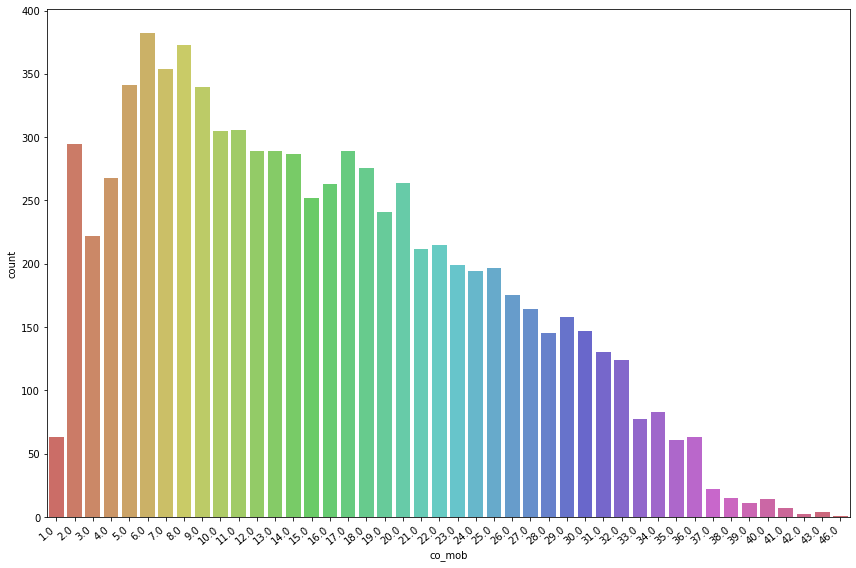

In [6]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='co_mob', data=data, palette='hls')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show();

Note, the histogram of CO_MOB is not the probabilty of CO in that mob. If a loan was not charged-off (it was paid in full or pre-paid), its co_mob would be NaN and it would not appear in this graph. Therefore, this graph describes $ P(\text{co_mob} | \text{the loan is a charge-off}) $.

As pointed out above, a loan that did not CO will have a nan co_mob. Let's use that to make our target and drop it from the data

In [7]:
target = data['co_mob'].notna()
data = data.drop(columns='co_mob')

## Features types

Present the data types of each feature

In [8]:
data.dtypes

all804                           float64
rep501                           float64
hr24s                            float64
rt24s                            float64
iln703                           float64
hr06s                            float64
g099a                            float64
iln720                           float64
percent_funded                   float64
hr09s                            float64
loan_amnt                        float64
rev401                           float64
debt_to_income                   float64
g099s                            float64
all803                           float64
st27s                            float64
g960s                            float64
g230s                            float64
all807                           float64
mt47s                            float64
g094s                            float64
all801                           float64
g104s                            float64
s004s                            float64
funding_threshol

Let's take a look at the non-numeric features (you can use pd.DataFrame.select_dtypes); what are they?

In [9]:
data.select_dtypes(exclude='number')

,occupation,borrower_city,issue_date
id,,,
733477,Other,Hialeah,2017-01-31
768878,Professional,MARIETTA,2017-03-31
742473,None,SAGLE,2017-02-28
738121,Waiter/Waitress,QUINCY,2017-02-28
733109,Tradesman - Carpenter,JUNEAU,2017-01-31
...,...,...,...
738916,Nurse's Aide,Victorville,2017-02-28
754430,Skilled Labor,Mora,2017-03-31
755852,Food Service,HARVEY,2017-03-31


So, we have 3 non-numeric features: borrower_city, issue_date and occupation. Let's handle them.

### Borrower city

How many loans come from each city? 

In [10]:
data.borrower_city.value_counts()

CHICAGO        284
HOUSTON        250
Las Vegas      222
LAS VEGAS      213
MIAMI          210
              ... 
GRIFFIN          1
Pontotoc         1
Mexia            1
BRIMFIELD        1
HADDON HGTS      1
Name: borrower_city, Length: 9560, dtype: int64

This is a categorical feature with almost all distinct values (~10,000 values in 40,000 rows), so it is unlikely that it can be useful in predictions. Also, it's not nice to discriminate based on ones geography, let's drop it!

In [11]:
data= data.drop(columns=["borrower_city"])

### Issue date

Issue date is ordinal, so we can label encode it (you can use sklearn.preprocessing.LabelEncoder or OrdinalEncoder)

In [12]:
from sklearn.preprocessing import OrdinalEncoder
data["issue_date"] = np.squeeze(OrdinalEncoder().fit_transform(data[["issue_date"]]))

In [13]:
data["issue_date"]

id
733477    1.0
768878    3.0
742473    2.0
738121    2.0
733109    1.0
         ... 
738916    2.0
754430    3.0
755852    3.0
763440    3.0
739533    2.0
Name: issue_date, Length: 40249, dtype: float64

### Occupation

Occupation is not ordinal, but we can target encode it. That is, for each category, replace it with the numeric value of the mean of the target over all elements that belong to that category. However, we first need to split into train and test in order to compute the encoder only on the train set.

## Split to train and test

### TODO need to add something about co_amount

As you already know, we need to split our data to train and test.
So.. let's make a 70/30 split!

Set you training and test sets to be X_train, y_train, X_test and y_test.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target)

Now that we have a train set we can target encode the occupation feature. Compute the encoding on the training set.

In [15]:
encoder = y_train.groupby(X_train['occupation'].fillna('NA')).mean()

In [16]:
encoder

occupation
Accountant/CPA              0.156156
Administrative Assistant    0.189711
Analyst                     0.161954
Architect                   0.133333
Attorney                    0.151659
                              ...   
Tradesman - Electrician     0.229730
Tradesman - Mechanic        0.201954
Tradesman - Plumber         0.130435
Truck Driver                0.265672
Waiter/Waitress             0.231405
Name: co_mob, Length: 71, dtype: float64

Use the encoder to transform occupation in both the train and test sets.

In [17]:
X_train['occupation'] = X_train['occupation'].fillna('NA').map(encoder)
X_test['occupation'] = X_test['occupation'].fillna('NA').map(encoder)

<ipython-input-17-f3ef728ce022>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['occupation'] = X_train['occupation'].fillna('NA').map(encoder)
<ipython-input-17-f3ef728ce022>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['occupation'] = X_test['occupation'].fillna('NA').map(encoder)


## Number of rows and columns

Find the number of rows and columns

In [18]:
print("Train:")
print(f"Number of rows: {X_train.shape[0]} \nNumber of columns: {X_train.shape[1]}")
print("Test: ")
print(f"Number of rows: {X_test.shape[0]} \nNumber of columns: {X_test.shape[1]}")

Train:
Number of rows: 30186 
Number of columns: 52
Test: 
Number of rows: 10063 
Number of columns: 52


# Logistic Regression - Assumptions

As with the linear regression model, the logistic regression model also has assumptions that need to be met:
1. The target variable is binary.
2. There is no multicollinearity among the features.
3. A linear relationship between the features and the logit of the target.  
 $target \sim Bernouli(p(X))$ where $logit(p_{\beta}(X)) = X\beta$ or, equivalently, $p_{\beta}(X) = logit^{-1}(X\beta)$

Let's check these assumptions step by step.

## Exploring the target variable

Let's check how many charge offs we have:

In [19]:
y_train.value_counts()

False    24057
True      6129
Name: co_mob, dtype: int64

Remember: True refers to charge-off, and False refers to no charge-off.

What is the percentage of loans with CO?

In [20]:
y_train.mean()

0.20304114490161002

Compute the (absolute) correlations between each feature and the target

In [21]:
X_train.corrwith(y_train).abs().sort_values(ascending=False)

co_amount                 0.755750
int_rate                  0.238984
credit_score              0.154498
all801                    0.120851
bc102s                    0.120137
debt_to_income            0.118603
all804                    0.117936
total_inquiries           0.117358
rev703                    0.113920
all807                    0.112720
s004s                     0.112455
inquiries_last6_months    0.111996
all803                    0.111198
occupation                0.107511
re102s                    0.106655
bac302                    0.106261
rev302                    0.104197
g960s                     0.100580
rep901                    0.090106
rep071                    0.088710
rev401                    0.088265
rep001                    0.088101
mt36s                     0.083058
mt47s                     0.082553
all301                    0.079820
iln703                    0.058555
iln720                    0.056838
g104s                     0.055843
monthly_pmt         

Okay, so co_amount is, unsurprisingly, very correlated with the label. For the moment, though, let's leave it inside the trainig set and see how it effects our results.

Plot the distributions of the next two most correlated features, conditioned on the target varible (i.e. one plot for each class in that target; you can use `hue=target` when using the seaborn suite). 

04:56:50 WARNING legend.py         :1225 | No handles with labels found to put in legend.


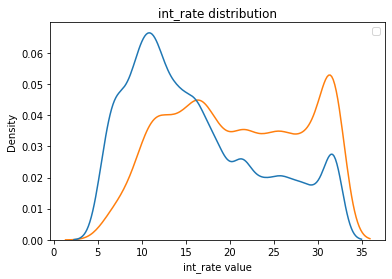

In [22]:
sns.kdeplot(x=X_train['int_rate'], hue=y_train, common_norm=False)
plt.title('int_rate distribution')
plt.legend()
plt.xlabel('int_rate value')
plt.ylabel('Density')
plt.show();

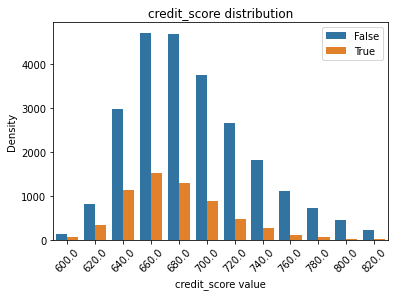

In [23]:
sns.countplot(x=X_train['credit_score'], hue=y_train)
plt.title('credit_score distribution')
plt.legend()
plt.xlabel('credit_score value')
plt.ylabel('Density')
plt.xticks(rotation=45)
plt.show();

## Multicollinearity

You are already familiar with the concept of multicollinearty from assignment 3.  

Reminder:
* Multicollinearity occurs when two or more explanatory variables are highly correlated to each other,\
  such that they do not provide unique or independent information in the regression model.  
  If the degree of correlation is high enough between variables, it can cause problems when fitting and interpreting the model. 

Multicollinearity can significantly impair the performance of logistic regression, so let's test for it and remove it

(You can use seaborn.clustermap to vizualize the correlation matrix)

<Figure size 3240x3240 with 0 Axes>

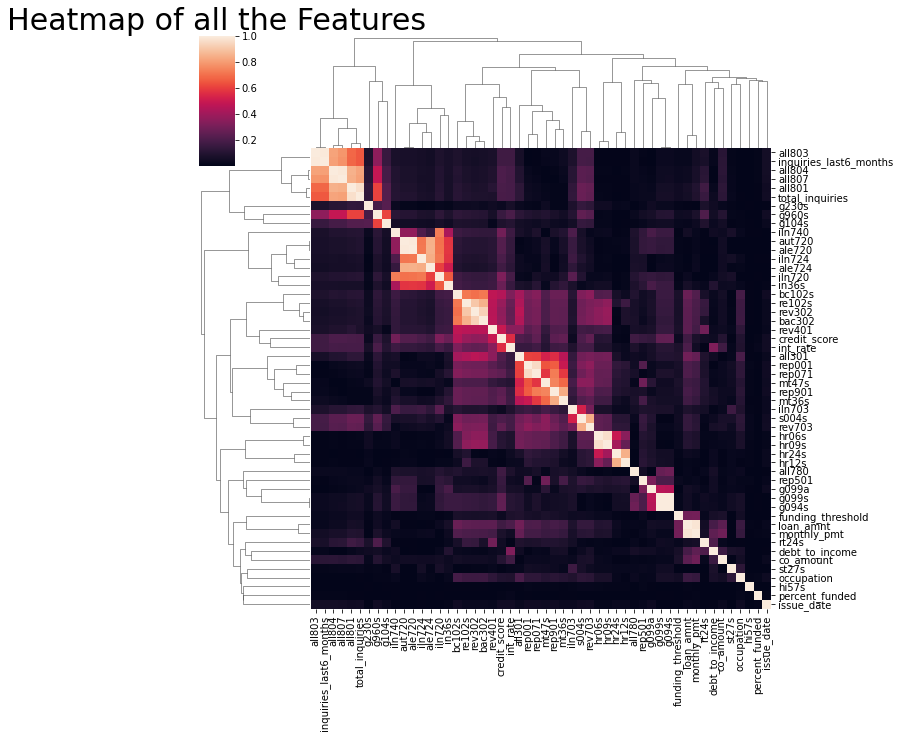

In [24]:
plt.figure(figsize=(45, 45))
sns.clustermap(X_train.corr().abs(), xticklabels=True, yticklabels=True)
plt.title("Heatmap of all the Features", fontsize = 30)
plt.show()

Right!  
The correlations between the features need to be examined and if there are high correlations between certain features then they are interdependent and we better take care of that.

In the heatmap we can see several features that are highly correlated to others. There are more involved ways for choosing which features to keep, but in this case we will simply drop those features which are more correlated to other features as well. Select a set of features that are strongly correlated to other features and drop them.

_remark_ There are more involved ways for choosing which features to keep, but in this case we will simply drop those features which are more correlated to other features as well

We chose to remove the following features:

In [25]:
features_to_remove = ['all803', 'all804', 'all801', 'aut720', 're102s', 'rev302', 'bac302', 'rep001', 'rep071', 'rep901', 's004s', 'hr06s', 'g099s', 'monthly_pmt', 'hr24s', 'all807', 'ale724', 'ale720', 'in36s', 'mt47s']

In [26]:
X_train.shape, X_test.shape

((30186, 52), (10063, 52))

In [27]:
X_train = X_train.drop(columns=features_to_remove)
X_test = X_test.drop(columns=features_to_remove)

In [28]:
X_train.shape, X_test.shape

((30186, 32), (10063, 32))

Make sure the correlation map looks closer to diagonal now.

<Figure size 2160x2160 with 0 Axes>

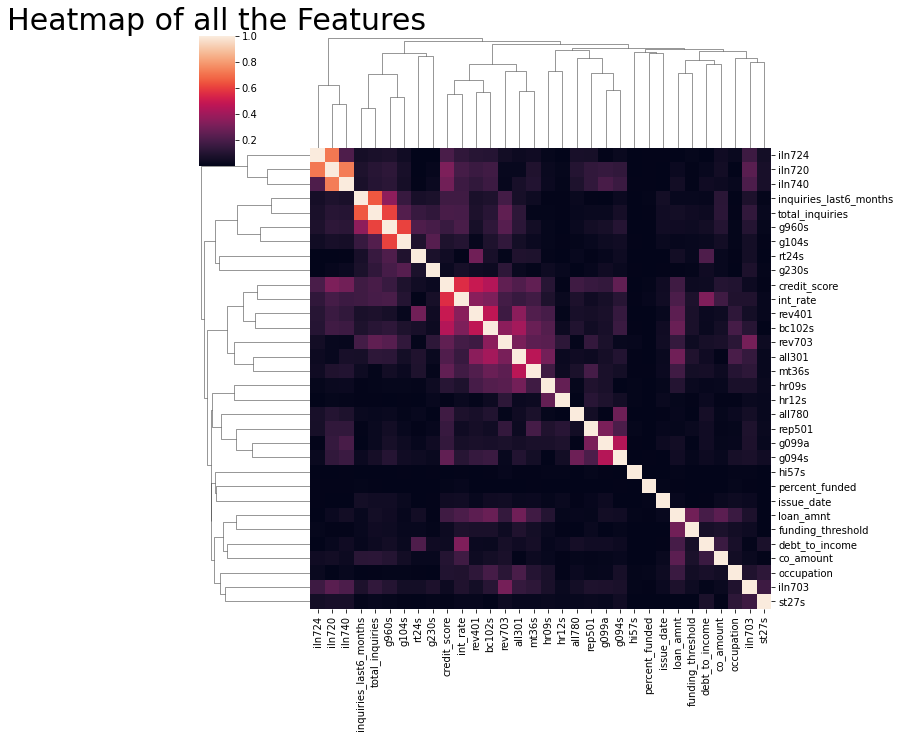

In [29]:
plt.figure(figsize=(30, 30))
cm = sns.clustermap(X_train.corr().abs(), xticklabels=True, yticklabels=True);
plt.title("Heatmap of all the Features", fontsize = 30);
plt.show()

There are still some correlations but this is much closer to an identity matrix

# Cleaning the data

Until now we got to know our data and checked if they meet the required assumptions.  
Now, let's start cleaning the data.

Find out the percentage of missing values (i.e. np.nans) in your dataset, and print them in ascending order. 

## Missing values

Find out the percentage of missing values (i.e. NaNs) in your dataset, and print them in ascending order. 

In [30]:
X_train.isna().sum().sort_values()

rep501                    0
occupation                0
int_rate                  0
credit_score              0
total_inquiries           0
inquiries_last6_months    0
rev703                    0
iln724                    0
mt36s                     0
all780                    0
iln740                    0
bc102s                    0
hr12s                     0
all301                    0
hi57s                     0
funding_threshold         0
g104s                     0
g094s                     0
g230s                     0
g960s                     0
st27s                     0
debt_to_income            0
rev401                    0
loan_amnt                 0
hr09s                     0
percent_funded            0
iln720                    0
g099a                     0
iln703                    0
rt24s                     0
co_amount                 0
issue_date                0
dtype: int64

How many missing values are the in the dataset? What's the percentage of rows without any missing features?

<span style="color:teal">No missing values</span>

If everything went smoothly, there should be no missing values here, so.. nothing left to do :)

<span style="color:teal"> if the interns forget to fillna in the occupation encoding, they would have nans here- make sure to remind them about it</span>

## Outliers

If there are outliers, you can choose one of the following ways:
1. Use methods (such as XGBoost) which handle outliers inherently.
2. Remove them.
3. Replace them with a value like the mean/median.
4. Simply keep them in order to learn from them (but make a note about this when reporting the regression results).

Let's focus on two features we understand and find outliers in them:
1) loan_amnt - the amount of the loan in USD.
2) listing_term - the number months the loan was taken for.

In order to find outliers we will plot a box plot for each feature.

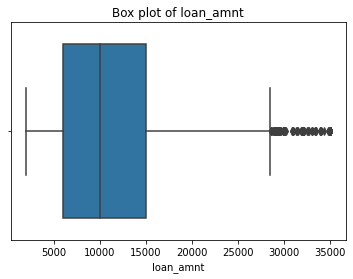

In [31]:
sns.boxplot(x=X_train['loan_amnt'])
plt.title('Box plot of loan_amnt')
plt.show()

There seem to be many outliers with large loan amounts. However, we expect loan amount to have some very large values.  
We can assume that the loan amount behaves log-normal (which means its Log behaves normally), therefore it might be more insightful to plot the Log of the feature.

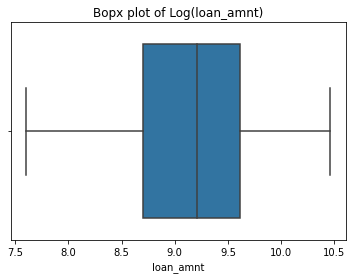

In [32]:
sns.boxplot(x=np.log(X_train['loan_amnt']))
plt.title('Bopx plot of Log(loan_amnt)')
plt.show()

This looks much better! 

Let's explore how many outliers we have in this feature. 
In general outlier is not a well-defined notion. One possible defition in our case would be loans whose loan amount is noticably higher or smaller than expected. For example in the case of a normal distribution, values more then $3*std$ from the mean are often considered outliers. A useful rule of thumb for finding outliers in many cases is by computing the interquantile range (IQR, i.e. the difference between the third and first quartile) and finding all loans whose log(loan amount) is more then some constant times the IQR from a given percentile.

Compute the IQR of the log of loan amount.

In [33]:
Q1 = np.log(X_train['loan_amnt']).quantile(0.25)
Q3 = np.log(X_train['loan_amnt']).quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

Compute the number of loans in X_train whose log(loan_amount) is more than $1.5*IQR$ below the 25th percentile of the feature.

In [34]:
below_range = (np.log(X_train['loan_amnt']) < Q1 - 1.5 * IQR) 
print(f"Number of outliers below range: {below_range.sum()}")

Number of outliers below range: 0


Compute the number of loans in X_train whose log(loan_amount) is more than $1.5*IQR$ above the 75th percentile of the feature.

In [35]:
above_range= (np.log(X_train['loan_amnt']) > Q3 + 1.5 *IQR)
print(f"Number of outliers above range: {above_range.sum()}")

Number of outliers above range: 0


Cool, it seems that there are no outliers according to this specific definition.

Replace the loan_amnt feature by its log:

In [36]:
X_train['loan_amnt'] = np.log10(X_train['loan_amnt'])
X_test['loan_amnt'] = np.log10(X_test['loan_amnt'])

# Preprocessing

We did most of the data preparation while working.  
The last thing we need to do is to handle categorical features (usually by creating dummy variables or label encoding).  
However, we already know there are no categorical features in our training set so our data is ready! 

# Model train

So, now that our data is ready, we can create and train our model. As we discussed in Section 3, we will use a logistic regression model for this purpose.
Use the `sklearn.linear_model.LogisticRegression` package to create your model. As we've seen in Assignment 1, regression models' performance improve if the data is standardized before fitting. In order to add a standartization step to your model you can use `sklearn.preprocessing.StandardScaler` and use `sklearn.pipeline.PipeLine` in order to run the two processes in sequence.

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [38]:
ss = StandardScaler()
lr = LogisticRegression(max_iter=500, penalty='none')
pp = Pipeline([('scaling', ss), ('lr', lr)])

Fit your model to the training data

In [39]:
pp.fit(X_train, y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('lr', LogisticRegression(max_iter=500, penalty='none'))])

Let's check our model's performance. Our measure of accuracy would be the percentage of items in the test set for which the prediction is identical to the true value (i.e. the percantage of loans for which model predicted True for a CO loan or False for a non-CO loan).

You can either compute this value directly, or use `sklearn.metrics.accuracy_score`.

In [40]:
from sklearn import metrics
metrics.accuracy_score(y_test, pp.predict(X_test))

0.9969194077312928

If all went according to plan, this should be way too good to be true, and make us suspicious. 
Let's have a closer at the trained model. Use `sklearn.linear_model.LogisticRegression`'s coef_ attribute in order to see the regression coefficient corresponding to each feature. By default - the coefficients appear in the same order as the corresponding columns appear in X_train.

Find a nice way to represent the coefficients and their respective column names and print it. How do the coefficients look?

In [41]:
pd.Series(np.squeeze(lr.coef_), index=X_train.columns).abs().sort_values(ascending=False)

co_amount                 199.755384
int_rate                    0.488551
all301                      0.337470
g104s                       0.333047
total_inquiries             0.287753
mt36s                       0.284586
credit_score                0.260573
iln703                      0.251995
iln724                      0.249332
iln720                      0.246858
issue_date                  0.243035
funding_threshold           0.197459
rep501                      0.194841
loan_amnt                   0.193693
rt24s                       0.192476
debt_to_income              0.182719
g094s                       0.132357
occupation                  0.107180
g099a                       0.085266
g230s                       0.080642
inquiries_last6_months      0.076576
st27s                       0.067101
iln740                      0.062472
rev401                      0.056295
hr09s                       0.044105
g960s                       0.030163
all780                      0.022425
p

Oh no! co_amount is not supposed to be a feature, it represents the performance of the loan and leaks information about the target (which we obviously won't have in real life before the loan is financed)! This is not surprising- we already saw that it is highly correlated with the target variable.

Let's fix it. Drop the co_amount column from the training and test sets.

In [42]:
X_train = X_train.drop(columns='co_amount')
X_test = X_test.drop(columns='co_amount')

Good, now let's retrain and see what we get. Fit the model to the new training set (without co_amount) and assess its performance, as above.

In [43]:
pp.fit(X_train, y_train)
preds = pp.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.8008546159197059

80% accuracy sure seems like a good start. HOWEVER, we saw that there are ~20% charge offs, so a model that predicts all False would essentially perform the same.
Let's look at a confusion matrix of our predictions vs. the true labels, to see if this is the case. Create a confusion matrix using `sklearn.metrics.plot_confusion_matrix`.

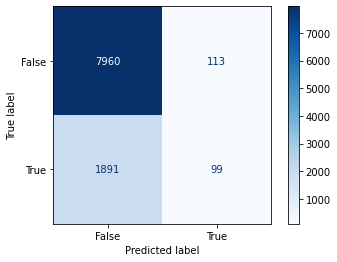

In [44]:
metrics.plot_confusion_matrix(pp, X_test, y_test,
                             cmap=plt.cm.Blues)

Yes, so it seems that our model predicts pretty much all as non-CO. In fact, let's compare to **really** 
predicting non-CO for all loans:

In [45]:
metrics.accuracy_score(y_test, [False] * len(y_test))

0.8022458511378316

Looks like even the accuracy of always predicting False is almost as good as our model. This is not great..

Moreover, **and this is very important**, in our case not all errors are equally important. A loan with 5% interest rate will yield ~16% of the original loan amount after 3 years ($(1+0.05)^3 -1 = 15.8$), if it repays in full. However, a loan that COs could cost us up to 100%! Therefore, it is **much more important** for us to correctly identify CO's than non-CO's.

Let's see how the accuracy looks if we weighted the COs as 5x (and it is plausible to give it even higher weights). Use `skelearn.metrics.accuracy_score`'s sample_weight parameter to add a weight of 5 to each True prediction of the model.

In [46]:
metrics.accuracy_score(y_test, preds, sample_weight=(1 + y_test * 4))

0.46912278754924264

## Using a weighted model

Of course, the lower accuracy score in the last section is not the model's fault, because we didn't train it to predict with sample weights. But we can retrain the model and give COs higher weights then non-CO loans - let's see what that looks like

Create a linear regerssion model as above with a weight of 5 to each CO loan and 1 for non-CO loans. You can use `sklearn.linear_model.LogisticRegression`'s class_weights parameter for this.

In [47]:
ss5 = StandardScaler()
lr5 = LogisticRegression(max_iter=500, penalty='none')
pp5 = Pipeline([('scaling', ss5), ('lr', lr5)])
pp5.fit(X_train, y_train, lr__sample_weight=(1 + y_train * 4))

Pipeline(steps=[('scaling', StandardScaler()),
                ('lr', LogisticRegression(max_iter=500, penalty='none'))])

What is the model's accuracy score?

In [48]:
pp5.fit(X_train, y_train, lr__sample_weight=(1 + y_train * 4))
preds = pp5.predict(X_test)
metrics.accuracy_score(y_test, preds, sample_weight=(1 + y_test * 4))

0.6566054485934639

Let's see the precentage of false positive and true negatives using a confusion matrix.

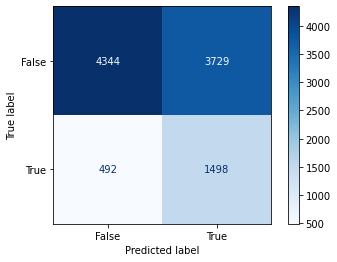

In [49]:
metrics.plot_confusion_matrix(pp5, X_test, y_test,
                             cmap=plt.cm.Blues)

Looks like our model now predicts many more loans as CO than before. Now that we see that changing the weights improve desirable properties of the model, how do we know how to find the *optimal* weights? In fact, in our case we might be able to bypass this problem.

Our logistic regression model predicts the probability of each loan charging off and, by default, flags the loan as CO if it has more than 50% probability of charging off (and non-CO otherwise). Instead of trying various weights and seeing which loans have a probability > 0.5 under these weights, we can decide to label a loan as CO even for a predicted 25%. Or 10%. Or any other threshold. We can then plot the Reciever-Operator Curve (ROC) which tells us the TPR (True Positive Rate) vs. FPR (False Positive Rate) induced by each choice of threshold.

First, in order to see that, indeed, changing the weights is equivalent to changing the threshold instead, let's plot the predicted probabilities for the unwighted model compared with the weighted model and look at the correlation of predictions for both models. 
To obtain the predicted probabilities (instead of the T/F prediction) use the models' predict_proba attribute.

Create a scatter plot of the predicted probabilities of the unweighted model vs those of the weighted model.

/root/wd/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

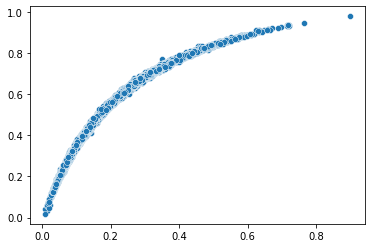

In [60]:
sns.scatterplot(pp.predict_proba(X_test)[:, 1], pp5.predict_proba(X_test)[:, 1])

Compute the Spearman rank correlation between the predicted probabilities of the two models. A Spearman correlation is a good choice for this type of comparison, because it evaluates the degree to which the models agree about ranking the loans with respect to their probability of CO.

In [51]:
from scipy.stats import spearmanr
spearmanr(pp.predict_proba(X_test)[:, 1], pp5.predict_proba(X_test)[:, 1])

SpearmanrResult(correlation=0.9993877246271126, pvalue=0.0)

Cool, so we indeed get very good correlation

Now let's look at the ROC of this model. Use `sklearn.metrics.plot_roc_curve` to create a ROC of the first (unweighted) model.

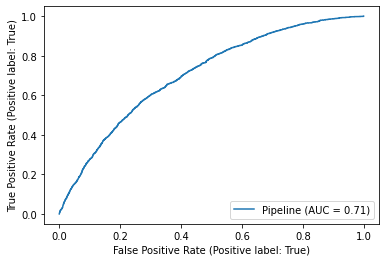

In [61]:
metrics.plot_roc_curve(pp, X_test, y_test)

Now we know what our options are for trading-off FPR and TPR. The question remains - how do we know which tradeoffs are reasonable?
In our case there are other metrics we can use in order to test our model's performance. Our main goal for training this model is to maximize returns, so it makes sense to evaluate the performance of the model by measuring the performance of our portfolio. We will use [IRR](https://www.investopedia.com/terms/i/irr.asp) to measure the portfolio's yield.

# Computing IRR of different portfolios

In order to compute the IRR of our portfolio we need to get the cashflow (i.e. the payments made for each loan) for our portfolion. We have provided you with a dataframe of precalculated cashflows indexed according to your data.

In [ ]:
cashflows = pd.read_parquet(os.path.join(ASSIGNMENT4_DATA,"prosper_cashflows.parquet"))

The following function receives a dataframe of cashflows and a list of indices and returns the IRR of the portfolio given by these indices.

In [62]:
import numpy_financial as npf
def get_portfolio_irr(cashflows, indices):
    """
    cashflows- a dataframe of cashflows 
    indices- pd.Series of T/F or a list of indices
    
    output: the yearly irr of the dataframe cashflows.loc[indices]
    """
    return (((npf.irr(cashflows.loc[indices].sum()) + 1) ** 12) - 1) * 100

Compute the IRR of the test set:

In [54]:
get_portfolio_irr(y_test)

3.7532037087969483

Now compute the IRR of all the loans in the test set which were predicted as non-CO:

In [55]:
get_portfolio_irr(y_test.loc[~pp.predict(X_test)])

4.026528852144984

This is a small improvement, let's see what the x5 weights model looks like:

In [56]:
get_portfolio_irr(y_test.loc[~pp5.predict(X_test)])

5.7902928861723435

This is a HUGE improvement! However, we haven't considered how much we had to reduce our volume to reach this return. Let's see what the effect is- compute the percentage of loans for the x5 weights model which managed are flagged as non-CO

In [57]:
(~preds).mean()

0.48057239391831463

So this cost us giving up more than 50% of the portfolio. 

If we have a given amount of money we want to invest we might be willing to settle for a slightly lower return in order to increase the amount of money yielding this return. We can make a plot similar to the ROC, but trading off the IRR on the y-axis and the deployed volume on the x-axis. This will allow us to evaluate these metrics, and interpret them from a buisness standpoint.

Let's have a closer look at this trade-off. Use the model's predict_proba attribute to find the set of loans which pass a threshold of 5%, 10%, 15%, ... 95%. For each such set, compute its volume (i.e. sum over loan_amnt) and its IRR. Create a curve which shows the volume vs IRR of each choice of threshold.

In [58]:
bins = pd.qcut(pp.predict_proba(X_test)[:, 1], 25)
irrs = (((cashflows.loc[y_test.index].groupby(bins).sum().cumsum().apply(npf.irr, axis=1) + 1) ** 12) - 1) * 100
volumes = (-cashflows.loc[y_test.index, 'loan_amnt'].groupby(bins).sum().cumsum())

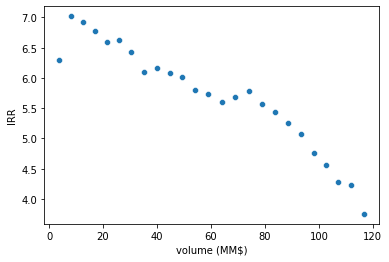

In [59]:
sns.scatterplot(x=volumes / 1_000_000, y=irrs)
plt.xlabel('volume (MM$)');
plt.ylabel('IRR');

Now this graph shows us the tradeoff between the return and the deployed volume. Given this graph we are left with the buisness question of where along this tradeoff we wish to be, which will determine the threshold we should choose.

# Now share your model 

Now that your model is ready, it's time to create a package which streamlines it's usage.
Do the following:
* Inside the `pagayapro` repo, create a branch called `feature/{your_names}/co_classifier/`
* Inside `~/pagayapro/assignment3/`, create a folder called `models/{your_names}/` and in it a python package which contains a class for the model (you may choose the class's name). The class should have the attributes `fit`, `predict` and `predict_proba`.
* The attribute `fit` should accept two variable, X and y, preprocess them according to the steps you've undertaken in this notebook and fit a logistic regression model to the preprocessed data.
* The attribute `predict` should accept a test set X_test, preprocess it accrodingly, and return an array of boolean prediction for each row of X_test- True for CO and False for non-CO. The attribute `predict_proba` return the predicted probability of each row.
* Once you package is ready, push it to the repo. Ask your mentor for a review. Once the review is complete, rebase and merge your package to the repo.

# One last remark

An important thing we ignored in this exercise is that increased risk is not necessarily a bad thing, as a higher interest rate could compensate for it, with a premium. A portfolio that has 10% CO might be better than one that has 5% CO, if the average interest rate of the former is 20% and 10% for the latter. In the next assignment, we will attempt to use this observation to further improve our ability to choose a good portfolio.